# Bitterness Classification With XGBoost

This example has been created as part of our Advanced Topics Webinar, scheduled for May 28, 2021. This webinar focuses on taking existing machine learning workflows and bringing them to the Exabyte platform.

In this notebook, we will train a model that predicts whether a molecule is bitter or not by using various structural descriptors. The dataset we use is from the BitterSweet dataset hosted in [kaggle](https://www.kaggle.com/katyaarnold/bittersweet). This dataset is actually the combination of several other databases, which are listed in the following publication:

Tuwani, R., Wadhwa, S. & Bagler, G. BitterSweet: Building machine learning models for predicting the bitter and sweet taste of small molecules. Sci Rep 9, 7155 (2019). https://doi.org/10.1038/s41598-019-43664-y 
    
## Imports

In addition to a few standard ML packages (pandas, sklearn, etc), we'll also import a few other packages:
 
- XGBoost: eXtreme Gradient Boosting. It's a gradient-boosting package that is a lot faster than the sklearn implementation. It also offers the option to apply dropout regularization to the ensemble via the DART algorithm (https://xgboost.readthedocs.io/en/latest/tutorials/dart.html)
- Imbalanced-Learn: This is a package offering variations on the Synthetic Minority Oversampling Technique (SMOTE) technique, which upsamples the minority class. This is helpful in the case of an imbalanced classification problem.
- Optuna: This is a hyperparameter optimization library. It implements bayesian optimization to sample the hyperparameter space, in order to maximize a model's predictive capabilities. We use it to tune some of XGBoost's hyperparameters (such as number of trees in the ensemble)
- RDKit: This is a cheminformatics package focused on molecules; it offers a wide range of descriptors and fingerprints for molecules.
    

In [1]:
!pip install numpy matplotlib pandas sklearn xgboost optuna imblearn rdkit_pypi

In [2]:
import functools

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import sklearn.preprocessing
import sklearn.pipeline

import xgboost 
import optuna
import joblib

import imblearn

from rdkit.Chem import MolFromSmiles, Lipinski
import rdkit.Chem.Descriptors as Descriptors


from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Read the Dataset
Let's begin by reading in the dataset. We have gently cleaned the CSV file, retaining only a few columns:

- Name: the name of the chemical
- Taste: Whether the material tastes sweet, bitter, non-bitter, or is tasteless
- Reference: The dataset the entry is from (see Tuwani et al for further details)
- SMILES: the SMILES string representing the molecule
- Canonical SMILES: a Canonical SMILES string (this helps us remove duplicate molecules)

We can see that the dataset contains comparable numbers of sweet/bitter molecules, along with several that have been labeled as either "tasteless" or "nonbitter"

In [3]:
# Data is from https://www.kaggle.com/katyaarnold/bittersweet
raw_data = pd.read_csv("../assets/bitter-sweet.csv")
print(raw_data.Taste.value_counts())
raw_data

Sweet         2483
Bitter        1829
Tasteless      416
Non-bitter      66
Name: Taste, dtype: int64


,Name,Taste,Reference,SMILES,Canonical SMILES
0,D-Fructose,Non-bitter,Wiener et al. (2017) - Phyto-Dictionary,OC[C@]1(O)[C@@H](O)[C@H](O)[C@@H](CO1)O,OC[C@@]1(O)OC[C@H]([C@H]([C@@H]1O)O)O
1,D-Glucose,Non-bitter,Wiener et al. (2017) - Phyto-Dictionary,OC[C@@H]1[C@@H](O)[C@H](O)[C@@H](O)[C@H](O1)O,OC[C@H]1O[C@H](O)[C@@H]([C@H]([C@@H]1O)O)O
2,D-Mannose,Non-bitter,Wiener et al. (2017) - Phyto-Dictionary,OC[C@@H]1[C@@H](O)[C@H](O)[C@H](O)[C@H](O1)O,OC[C@H]1O[C@H](O)[C@H]([C@H]([C@@H]1O)O)O
3,L-Rhamnose,Non-bitter,Wiener et al. (2017) - Phyto-Dictionary,C[C@H]1[C@H](O)[C@@H](O)[C@@H](O)[C@H](O1)O,O[C@H]1[C@H](C)O[C@@H]([C@@H]([C@@H]1O)O)O
4,D-Ribulose,Non-bitter,Wiener et al. (2017) - Phyto-Dictionary,OCC(=O)[C@H](O)[C@H](O)CO,OC[C@H]([C@H](C(=O)CO)O)O
...,...,...,...,...,...
4789,6-Methyl-2-pyridinemethanol,Bitter,The Good Scents Company Database,CC1=NC(=CC=C1)CO,OCc1cccc(n1)C
4790,4-hydroxybenzyl alcohol,Bitter,The Good Scents Company Database,C1=CC(=CC=C1CO)O,OCc1ccc(cc1)O
4791,4-Benzoylpyridine,Bitter,The Good Scents Company Database,C1=CC=C(C=C1)C(=O)C2=CC=NC=C2,O=C(c1ccncc1)c1ccccc1
4792,4-(5-Methyl-2-furyl)-2-butanone,Bitter,The Good Scents Company Database,CC1=CC=C(O1)CCC(=O)C,CC(=O)CCc1ccc(o1)C


# Process the Dataset
We're going to derive all of our properties from the structure of the molecule, which is represented in a SMILES string. We'll take the Canonical SMILES, which is a variant of SMILES that attempts to have only one representation for a molecule. This will help us detect duplicate entries.

Also, since binary classification is an easier problem, we'll take the all-versus-one approach to labeling. Specifically, we're going to predict whether a material is bitter or non-bitter. To do this, we'll use sklearn's built-in label binarizer, which takes in a list of classes and returns a numpy array containing a one-hot encoding of whether a row is a member of a given class. We'll then take the column for "Bitter" and append it to the pandas array.

Finally, we'll drop any missing entries from the dataset, and we'll then drop any duplicate rows (judged either by the name or canonical simles).

In [4]:
# Drop a few columns we don't want
data = raw_data[["Name", "Canonical SMILES"]].copy()

# Let's take a 1 v all approach to this, and just encode "Bitter" as 1 and everything else as 0.
classes = ("Sweet", "Bitter", "Tasteless", "Non-bitter")
binarized = sklearn.preprocessing.label_binarize(raw_data.Taste.to_numpy(), classes=classes)
bitter = binarized[:,classes.index("Bitter")]

data["Bitter"] = bitter
data = data.dropna()
for colname in data.drop(columns=["Bitter"]).columns:
    data = data.dropna().drop_duplicates(subset=colname)

data

,Name,Canonical SMILES,Bitter
0,D-Fructose,OC[C@@]1(O)OC[C@H]([C@H]([C@@H]1O)O)O,0
1,D-Glucose,OC[C@H]1O[C@H](O)[C@@H]([C@H]([C@@H]1O)O)O,0
2,D-Mannose,OC[C@H]1O[C@H](O)[C@H]([C@H]([C@@H]1O)O)O,0
3,L-Rhamnose,O[C@H]1[C@H](C)O[C@@H]([C@@H]([C@@H]1O)O)O,0
4,D-Ribulose,OC[C@H]([C@H](C(=O)CO)O)O,0
...,...,...,...
2423,6-Methyl-2-pyridinemethanol,OCc1cccc(n1)C,1
2424,4-hydroxybenzyl alcohol,OCc1ccc(cc1)O,1
2425,4-Benzoylpyridine,O=C(c1ccncc1)c1ccccc1,1
2426,4-(5-Methyl-2-furyl)-2-butanone,CC(=O)CCc1ccc(o1)C,1


# Feature Engineering

Consider that the "bitter" taste is caused by the interaction of molecules with certain proteins (see [here](https://en.wikipedia.org/wiki/Taste_receptor#Bitter)). For a molecule to bind at the appropriate binding site on a protein, it will need to have an optimal structure, in terms of its shape, how it's polarized, whether it can form hydrogen bonds, etc. For this reason, we'll take a few different descriptors using RDKit.

- NuMAromaticRings, the number of aromatic rings in the moleclue. Aromatic rings are typically greasy, and generally add steric bulk to a molecule, so they'll likely affect binding to the protein.
- NumHAcceptors, the number of hydrogen-bond acceptors (electronegative atoms with a lone pair) in the molecule. Proteins are littered with hydrogen bond donors/acceptors, so this will help provide information on the interaction with the protein.
- NumHDonors, the number of hydogen-bond donors (hydrogens bound to an electronegative atom) in the molecule. See above justification for why this matters to the binding prediction.
- MolWt, the molecular weight of the molecule. This is helpful as a description of the molecule's size, which in turn helps inform how it will bind to the protein.
- MinPartialCharge, the minimum partial charge in the molecule, estimated by RDKit. This (and the MaxPartialCharge) are helpful, in that they will help give an idea of how polarized the molecule is. Proteins tend to have polar/nonpolar regions, so this will help inform where the molecule can bind to the protein.
- MaxPartialCharge, the maximum partial charge in the molecule, estimated by RDKit. See above justification.
- And finally, we'll take some various density metrics of the Morgan Fingerprints supplied by RDKit.

Additionally, some of the SMILES strings in the dataset are incorrectly formatted (e.g. missing a closing character, or some other problem). To get around this, we'll surround the calculation of each descriptor in a try/except block. If we fail to calculate a descriptor, we'll just drop the row entirely.

In [5]:
# Let's get a bunch of descriptors into the dataset
descriptors = ((Lipinski.NumAromaticRings, "NumAromaticRings"),
               (Lipinski.NumHAcceptors, "HBondAcceptors"),
               (Lipinski.NumHDonors, "HBondDonors"),
               (Descriptors.MolWt, "MolecularWeight"),
               (Descriptors.MinPartialCharge, "MinPartialCharge"),
               (Descriptors.MaxPartialCharge, "MaxPartialCharge"),
               (Descriptors.FpDensityMorgan1, "FPDensityMorgan1"),
               (Descriptors.FpDensityMorgan2, "FPDensityMorgan2"),
               (Descriptors.FpDensityMorgan3, "FPDensityMorgan3"),
              )

# The dataset is a little unclean, with some badly-formatted SMILEs strings. We'll skip errors there, and just return None instead.
def get_descriptor(smiles, fun):
    try:
        result = fun(MolFromSmiles(smiles))
    except:
        result = None
    return result

for descriptor, name in descriptors:
    data[name] = data["Canonical SMILES"].apply(functools.partial(get_descriptor, fun=descriptor))

# And finally, we'll drop rows that didn't make it through the featurization
data = data.dropna()

# Train/Test Split

Next, we'll perform our train/test split. 10% of the data is kept out as a testing set, and 90% are kept in as a training set.

Also, we do have a slightly imbalanced dataset; roughly 2x as many non-bitter (0) compounds are in the dataset as there are bitter (1) compounds. To get around this, we'll use the SMOTE algorithm to appropriately upsample our dataset. Specifically, we'll use a variation of SMOTE that uses k-means to direct where it samples from the minority class, which a recent paper indicates outperforms vanilla SMOTE: https://arxiv.org/abs/1711.00837

In [6]:
print("Before Resample\n", data.Bitter.value_counts())

# Split into train/test sets
data_train, data_test = sklearn.model_selection.train_test_split(data, test_size=0.5)

x = data_train.drop(columns=["Name", "Canonical SMILES", "Bitter"]).to_numpy()
y = (data_train.Bitter).to_numpy()


# Upsample our training set with SMOTE
# Specifically, we'll use the K-Means variation of SMOTE - https://arxiv.org/abs/1711.00837
smote = imblearn.over_sampling.KMeansSMOTE(k_neighbors=10)
x_resample, y_resample = smote.fit_resample(x, y)

Before Resample
 0    1385
1     806
Name: Bitter, dtype: int64


# Prepare the Hyperparameter Optimization

Next, we'll use an sklearn pipeline with two steps:
1. A Standard Scaler, which standardizes each column such that it has a mean of 0 and standard deviation of 1. This is important, as many error metrics and algorithms operate on the assumption that (or, just work better when) the different descriptors are on similar scales.
2. XGBoost, a gradient boosting library which is a bit faster than the Sklearn implementation. In addition, it can apply an analogous method for dropout regularization to the trees, using the DART algorithm (see https://xgboost.readthedocs.io/en/latest/tutorials/dart.html)

We make a function that can create a pipeline in Sklearn, given a set of parameters. In Sklearn, we can access the parameters of an individual estimator by using the f"{estimator_name}\_\_{parameter}" syntax. The `create_pipeline` function takes in those parameters, and builds a pipeline.

Second, we have an `objective` function. The function tests a set of possible parameters for the pipeline, and returns a score (in this case the area under the ROC curve). Optuna's goal, then, is the find a set of hyperparameters that maximize the score of the training set. To help guard against overfitting, we use cross-validation to determine the score. Finally, we'll set Optuna to use hyperband optimization, which has been shown to perform well when combined with the default sampler - https://tech.preferred.jp/en/blog/how-we-implement-hyperband-in-optuna/

In [7]:
def create_pipeline(params):
    pipeline = sklearn.pipeline.Pipeline([
        
        ("StandardScaler", sklearn.preprocessing.StandardScaler()),
        ("XGBoostClassifier", xgboost.XGBClassifier( objective="binary:logistic",
                                                     eval_metric="logloss",
                                                     use_label_encoder=False))
    ])
    pipeline.set_params(**params)
    return pipeline
    
def objective(trial: optuna.Trial):
    with joblib.parallel_backend("loky"):      
        params = {
            "XGBoostClassifier__n_estimators": trial.suggest_int("XGBoostClassifier__n_estimators", 1, 1000),
            "XGBoostClassifier__eta": trial.suggest_loguniform("XGBoostClassifier__eta", 0.01, 0.4),
            "XGBoostClassifier__min_child_weight": trial.suggest_int("XGBoostClassifier__min_child_weight", 1,100),
            "XGBoostClassifier__max_depth": trial.suggest_int("XGBoostClassifier__max_depth", 3,50),
            "XGBoostClassifier__gamma": trial.suggest_uniform("XGBoostClassifier__gamma", 0, 1),
            "XGBoostClassifier__subsample": trial.suggest_uniform("XGBoostClassifier__subsample", 0, 1),
            "XGBoostClassifier__lambda": trial.suggest_loguniform("XGBoostClassifier__lambda", 0.1, 1000),
            "XGBoostClassifier__alpha": trial.suggest_loguniform("XGBoostClassifier__alpha", 0.1, 1000),
            "XGBoostClassifier__colsample_bytree": trial.suggest_uniform("XGBoostClassifier__colsample_bytree", 0.1,1),
        }
        pipeline = create_pipeline(params)
        
        score = sklearn.model_selection.cross_val_score(pipeline, x_resample, y_resample, scoring="neg_log_loss", n_jobs=1, cv=4).mean()
        return score

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.HyperbandPruner(min_resource=10, max_resource='auto'))

[I 2021-06-22 13:51:53,137] A new study created in memory with name: no-name-e082712e-8db1-463d-b7fb-45323f3a8781


# Optimize the Hyperparameters

Optuna will then use Bayesian optimization to efficiently sample the hyperparameter search space. This is signiifcantly faster than the brute force method of testing all possible combinations of hyperparameters (Grid Search), and more-intelligently samples the hyperparameter space than a Random Search would.

In [8]:
study.optimize(objective, n_trials=128, n_jobs=16)

/Users/mat3ra/PycharmProjects/exabyte-api-examples-2/.env/lib/python3.9/site-packages/optuna/study.py:394: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2021-06-22 13:51:56,446] Trial 0 finished with value: -0.6931471824645996 and parameters: {'XGBoostClassifier__n_estimators': 137, 'XGBoostClassifier__eta': 0.012042824383573895, 'XGBoostClassifier__min_child_weight': 55, 'XGBoostClassifier__max_depth': 27, 'XGBoostClassifier__gamma': 0.8152565848351799, 'XGBoostClassifier__subsample': 0.5422251190983566, 'XGBoostClassifier__lambda': 0.23230091208715845, 'XGBoostClassifier__alpha': 349.6435954337527, 'XGBoostClassifier__colsample_bytree': 0.16488357755923755}. Best is trial 0 with value: -0.6931471824645996.
[I 2021-06-22 13:51:57,636] Trial 16 finished with value: -0.6849600580130438 and parameters: {'XGBoostClassifier__n_estimators': 38, 'XGBoostClas

# Fit the Model to the Entire Training Set
Extract the best hyperparameters from the study and fit to our training set.

We'll also recall the cross-validated ROC AUC from the hyperparameter optimization.

In [9]:
pipeline = create_pipeline(study.best_params)
pipeline.fit(x,y)

# We don't need to re-evaluate the eror, since Optuna kept track of it for us.
cv_error = study.best_value

print(f"4-CV LogLoss: {-cv_error}")

4-CV LogLoss: 0.3666002125120985


# Evaluate the model against the test set

Here, we'll take the model that was trained on the training set, and get the ROC AUC score for the test-set data.

In [10]:
test_preds = pipeline.predict(data_test.drop(columns=["Name", "Canonical SMILES", "Bitter"]).to_numpy())
test_probs = pipeline.predict_proba(data_test.drop(columns=["Name", "Canonical SMILES", "Bitter"]).to_numpy())
test_score = sklearn.metrics.roc_auc_score(y_true=data_test.Bitter, y_score=test_probs[:,1])
fpr, tpr, threshes = sklearn.metrics.roc_curve(y_true=data_test.Bitter, y_score=test_probs[:,1])
threshes[0] -= 1

print(f"Test ROC AUC: {test_score}")

Test ROC AUC: 0.9014473740806056


# Test Set ROC Curve

Next, we'll plot the ROC curve for the testing set, and we'll evaluate the AUC for it. AUC=1 is a a classifier that perfectly predicts the correct result, AUC=0 is a classifier that perfectly predicts the wrong result (e.g. correct predictions can be had by inverting its predictions), and AUC=0.5 is a classifier that is equally as good as random guessing.

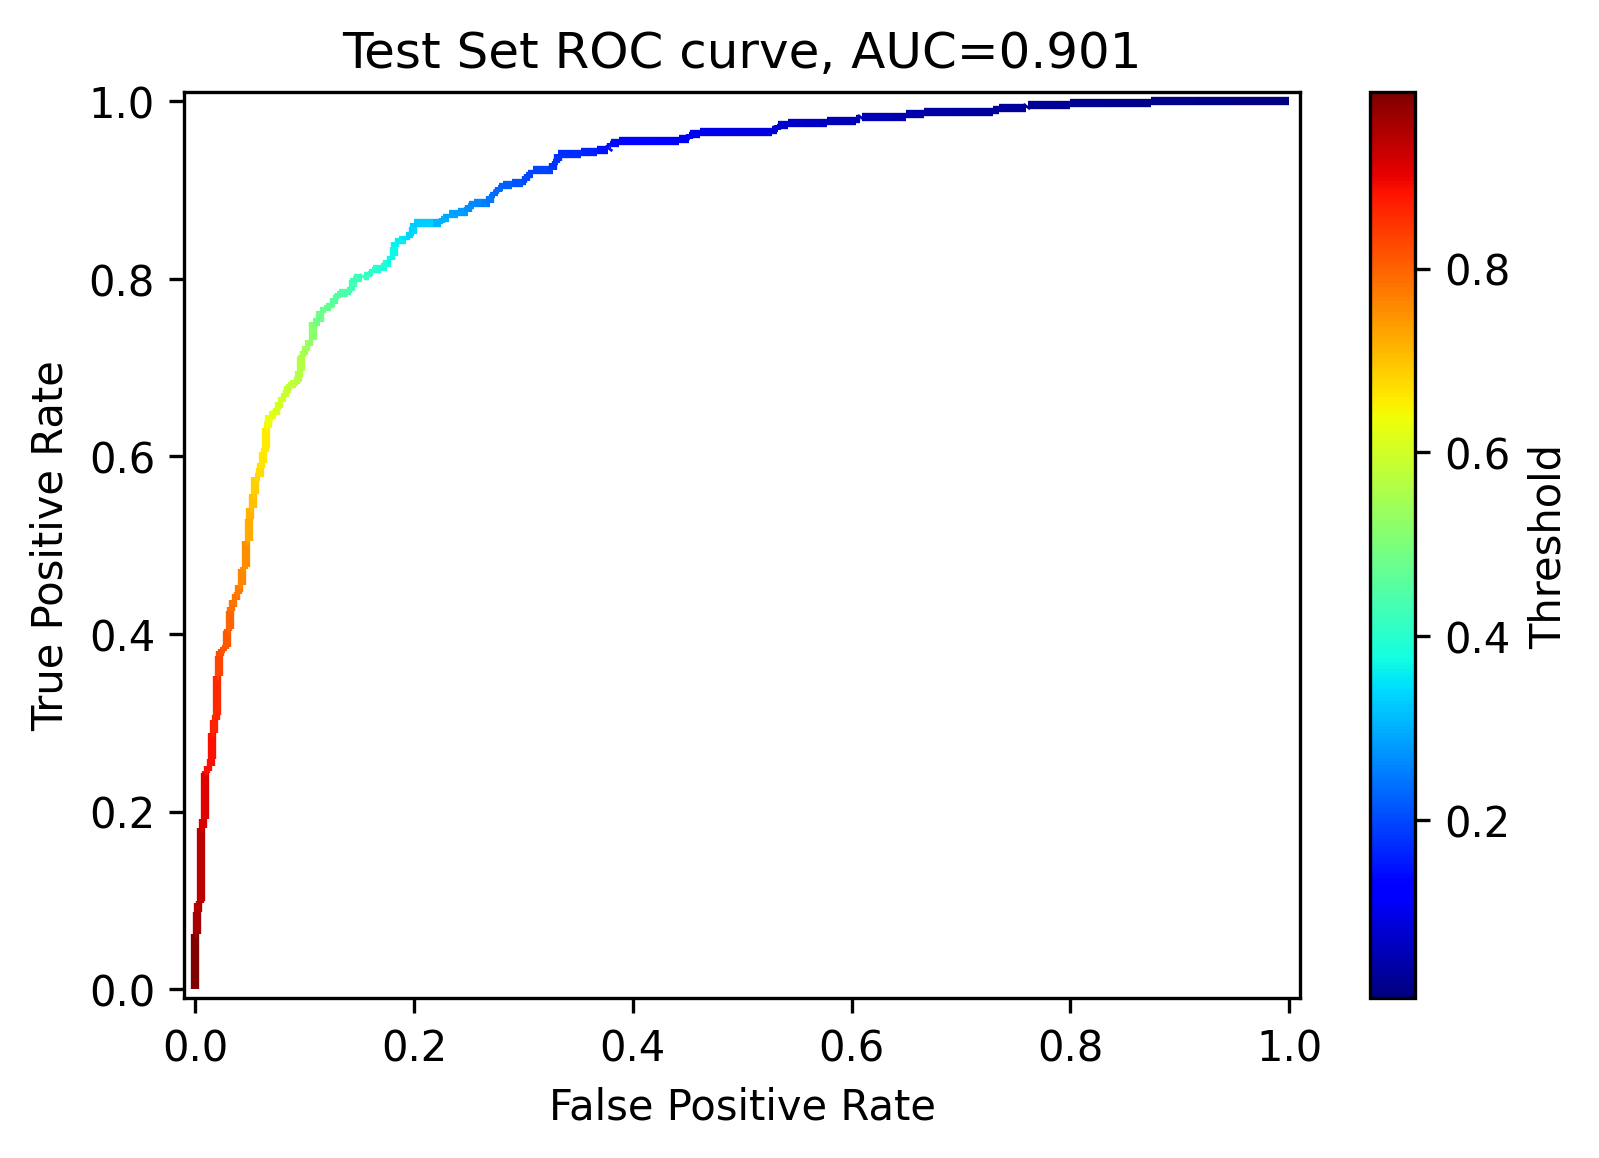

In [11]:
# Plot the curve
def draw_roc_curve(fpr, tpr, threshes, title):
    fig, ax = plt.subplots(dpi=300)
    points = np.array([fpr, tpr]).T.reshape(-1, 1, 2)

    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(threshes.min(), threshes.max())

    lc = matplotlib.collections.LineCollection(segments, cmap='jet', norm=norm, linewidths=2)
    lc.set_array(threshes)
    line = ax.add_collection(lc)
    fig.colorbar(line, ax=ax).set_label('Threshold')

    # Padding to ensure we see the line
    ax.margins(0.01)

    # plt.plot(false_positive_rate, true_positive_rate, c=colors, label=f"ROC2 Cure, AUC={roc_auc}")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
draw_roc_curve(fpr, tpr, threshes, f"Test Set ROC curve, AUC={np.round(test_score,3)}")

# Fit the Model to the Entire Dataset

At this point, we've assessed that the cross-validated ROC AUC of the training set is good, and that the test-set ROC AUC doesn't indicate that we're overfitting by much. We can now train the model on the entire dataset, using cross-validation to get an error estimate of the model.

In [12]:
# Now that we have a good idea of our error, let's retrain on the entire dataset
x_full = data.drop(columns=["Name", "Canonical SMILES", "Bitter"]).to_numpy()
y_full = data.Bitter.to_numpy()

# First, upsample using smote, as we did with the training set
x_full_resample, y_full_resample = smote.fit_resample(x_full, y_full)

# Finally, fit to the entire dataset
pipeline.fit(x_full_resample,y_full_resample)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('XGBoostClassifier',
                 XGBClassifier(alpha=0.19221034938852993, base_score=0.5,
                               booster='gbtree', colsample_bylevel=1,
                               colsample_bynode=1,
                               colsample_bytree=0.3342007885938862,
                               eta=0.08762415264009119, eval_metric='logloss',
                               gamma=0.44800326322606454, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               lambda=3.699839001189785,
                               learning_rate=0.087624155, max_delta_step=0,
                               max_depth=21, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=145,
                               n_jobs=12, num_parallel_tree=1, random_state=0,
                 

# ROC Curve - Entire Dataset

Finally, we'll take an ROC curve for when we use the entire dataset as the training set.

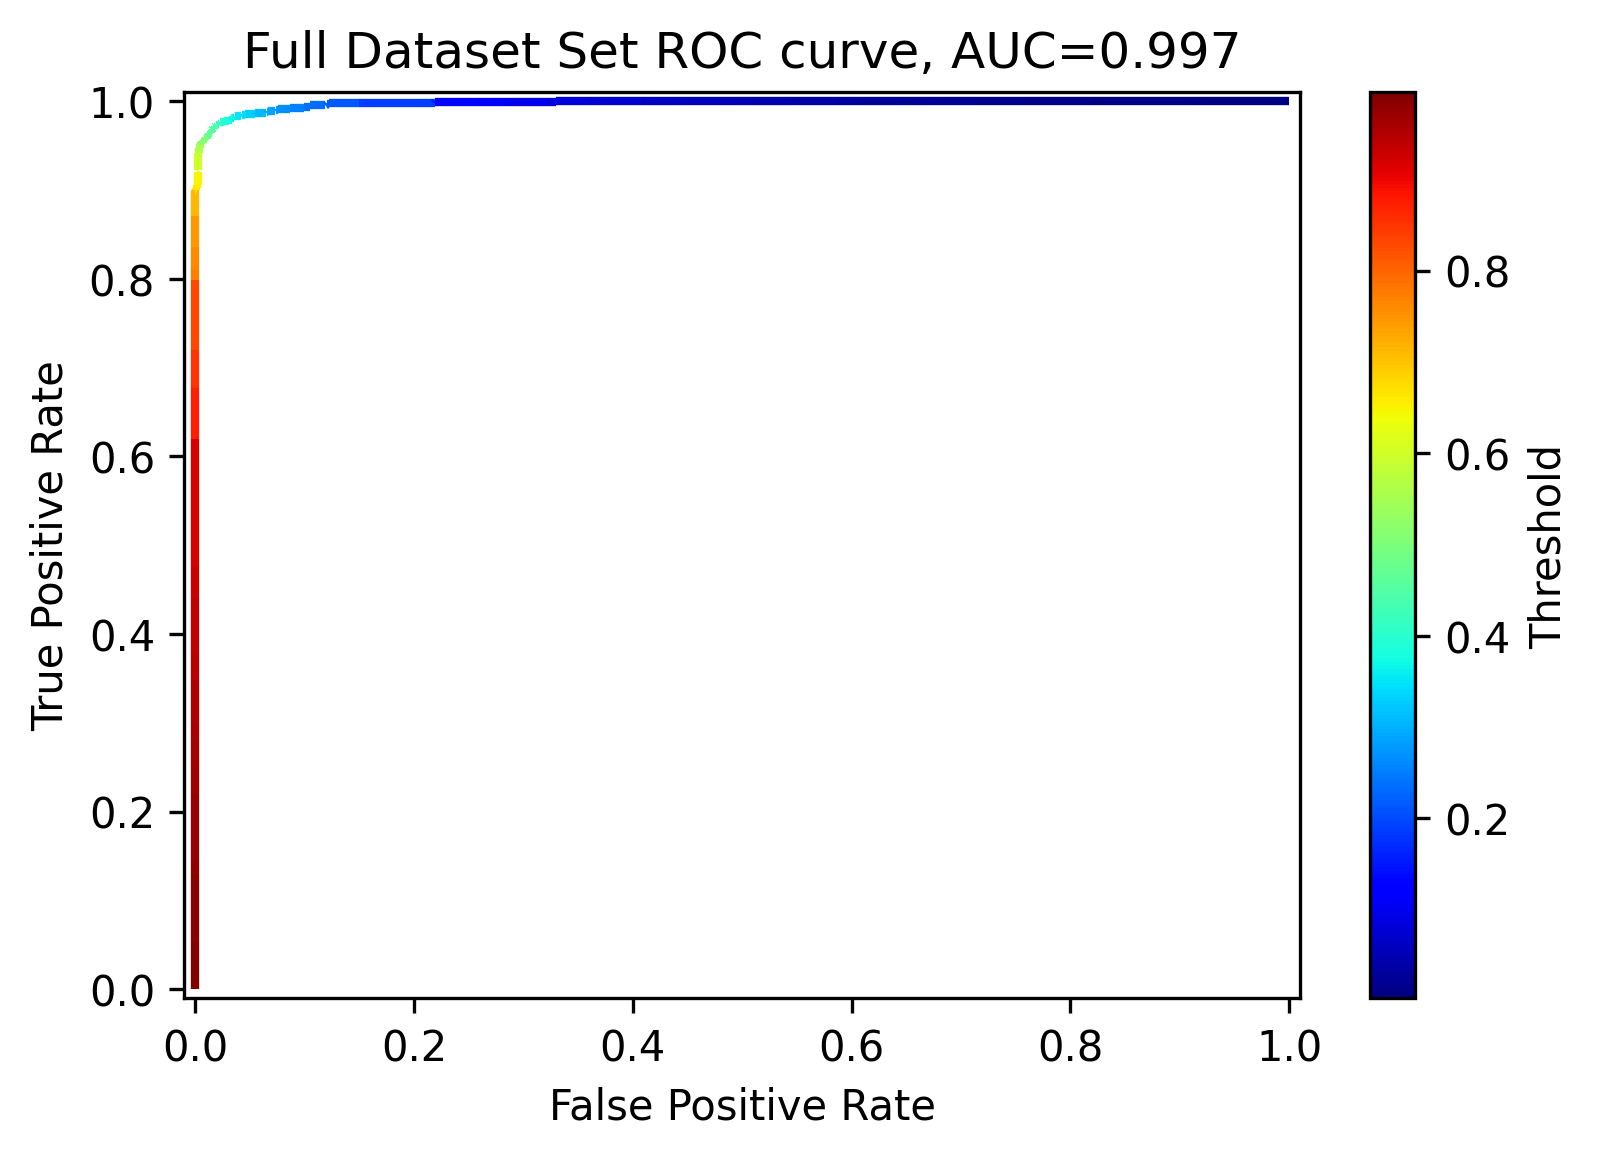

In [13]:
final_probs = pipeline.predict_proba(x_full)
final_score = sklearn.metrics.roc_auc_score(y_true=y_full, y_score=final_probs[:,1])
fpr, tpr, threshes = sklearn.metrics.roc_curve(y_true=y_full, y_score=final_probs[:,1])
threshes[0] -= 1
draw_roc_curve(fpr, tpr, threshes, f"Full Dataset Set ROC curve, AUC={np.round(final_score,3)}")

# Checking Specific Cases
As a sanity check, we'll look at the cases of Denatonium and Glycerine.

Denatonium is the most-bitter chemical known; it's oftentimes used as a bittering agent.

Glycerine (aka Glycerol) is a relatively sweet substance, used to make a variety of products. For example, its nitration leads to the production of nitroglycerine.


In [14]:
# Denatonium! Very bitter. It doesn't seem to be in the dataset.
print(data[data.Name == "Denatonium"])
print(data[data.Name == "Bitrex"])

# Glycerol! Probably tastes kinda sweet, but most certainly not bitter.
print(data[data.Name == "Glycerol"])

Empty DataFrame
Columns: [Name, Canonical SMILES, Bitter, NumAromaticRings, HBondAcceptors, HBondDonors, MolecularWeight, MinPartialCharge, MaxPartialCharge, FPDensityMorgan1, FPDensityMorgan2, FPDensityMorgan3]
Index: []
Empty DataFrame
Columns: [Name, Canonical SMILES, Bitter, NumAromaticRings, HBondAcceptors, HBondDonors, MolecularWeight, MinPartialCharge, MaxPartialCharge, FPDensityMorgan1, FPDensityMorgan2, FPDensityMorgan3]
Index: []
        Name Canonical SMILES  Bitter  NumAromaticRings  HBondAcceptors  \
15  Glycerol         OCC(CO)O       0               0.0             3.0   

    HBondDonors  MolecularWeight  MinPartialCharge  MaxPartialCharge  \
15          3.0           92.094         -0.393593          0.100047   

    FPDensityMorgan1  FPDensityMorgan2  FPDensityMorgan3  
15          1.166667               1.5               1.5  


In [15]:
names = [
    "Denatonium", 
    "Ethanol"
]
smiles = [
    "[O-]C(=O)c1ccccc1.Cc2cccc(C)c2NC(=O)C[N+](CC)(CC)Cc3ccccc3",
    "OCC"
]

new_data = pd.DataFrame.from_dict({
    "Name": names,
    "SMILES": smiles
})

for descriptor, name in descriptors: # Turn into a function
    new_data[name] = new_data.SMILES.apply(functools.partial(get_descriptor, fun=descriptor))
    
new_data["Predictions"] = list(map(lambda pred: "Bitter" if pred else "Non-Bitter", pipeline.predict(new_data.drop(columns=["Name", "SMILES"]))))
new_data

,Name,SMILES,NumAromaticRings,HBondAcceptors,HBondDonors,MolecularWeight,MinPartialCharge,MaxPartialCharge,FPDensityMorgan1,FPDensityMorgan2,FPDensityMorgan3,Predictions
0,Denatonium,[O-]C(=O)c1ccccc1.Cc2cccc(C)c2NC(=O)C[N+](CC)(...,3,3,1,446.591,-0.544815,0.279158,0.787879,1.30303,1.757576,Bitter
1,Ethanol,OCC,0,1,1,46.069,-0.396664,0.040221,2.000000,2.00000,2.000000,Non-Bitter


# Interpreting the Model: Feature Importance

Recall that the whether a molecule is bitter corresponds to whether it will bind strongly to a protein.

Without investigating the binding site of the protein itself (which would be a good idea if we wanted to study this further), we can check empirically whether a particular structural feature is important to whether a molecule will bind to the protein or not. This can give hints about how we might design a molecule that binds (or doesn't bind) to the receptors involved in determining bitterness.

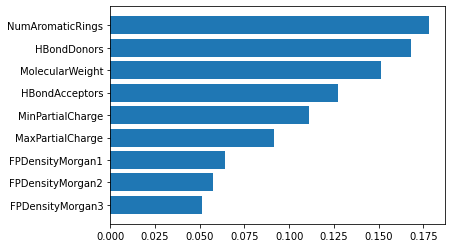

In [16]:
importances = pipeline["XGBoostClassifier"].feature_importances_
column_names = data_train.drop(columns=["Name", "Canonical SMILES", "Bitter"]).columns

plt.barh(range(len(importances)), sorted(importances))
plt.gca().set_yticks(range(len(importances)))
plt.gca().set_yticklabels(column_names[importances.argsort()])

plt.show()